In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

E:\anaconda3\envs\jcopml2\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Import Data

In [17]:
df = pd.read_csv("data/taxi_fare.csv", parse_dates=['pickup_datetime'])
df.dropna(inplace=True)
pickup_dt = df.pickup_datetime.dt
df['year'] = pickup_dt.year
df['month'] = pickup_dt.month
df['day'] = pickup_dt.day_of_week
df['hour'] = pickup_dt.hour
df.drop(columns="pickup_datetime", inplace=True)

df['distance'] = np.abs(df.pickup_longitude - df.dropoff_longitude) + np.abs(df.pickup_latitude - df.dropoff_latitude)
df.drop(columns=['pickup_longitude', 'dropoff_longitude', 'pickup_latitude', 'dropoff_latitude'], inplace=True)

df.head()

,fare_amount,passenger_count,year,month,day,hour,distance
0,4.5,1.0,2009,6,0,17,0.011742
1,16.9,1.0,2010,1,1,16,0.107481
2,5.7,2.0,2011,8,3,0,0.019212
3,7.7,1.0,2012,4,5,4,0.029386
4,5.3,1.0,2010,3,1,7,0.027194


# Dataset Splitting

In [3]:
X = df.drop(columns="fare_amount")
y = df.fare_amount

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15134, 6), (3784, 6), (15134,), (3784,))

# Training

In [4]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [5]:
rsp.enet_params

{'algo__fit_intercept': [True, False],
 'algo__alpha': Real(low=-4, high=2, prior='log-uniform'),
 'algo__l1_ratio': Real(low=0, high=1, prior='uniform')}

In [6]:
rsp.enet_poly_params

{'prep__numeric__poly__degree': Integer(low=1, high=3),
 'prep__numeric__poly__interaction_only': [True, False],
 'algo__fit_intercept': [True, False],
 'algo__alpha': Real(low=-4, high=2, prior='log-uniform'),
 'algo__l1_ratio': Real(low=0, high=1, prior='uniform')}

In [7]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2, transform='yeo-johnson'), ["passenger_count", "year", "distance"]),
    ('categoric', cat_pipe(encoder='onehot'), ["month", "day", "hour"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', ElasticNet())
])

model = RandomizedSearchCV(pipeline, rsp.enet_poly_params, cv=3, n_iter=100, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


E:\anaconda3\envs\jcopml2\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


{'algo__alpha': 0.0008632008168602546, 'algo__fit_intercept': True, 'algo__l1_ratio': 0.09997491581800291, 'prep__numeric__poly__degree': 3, 'prep__numeric__poly__interaction_only': False}
0.7087233168713427 0.7055922249587635 0.7348930408709083


E:\anaconda3\envs\jcopml2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.588e+05, tolerance: 1.403e+02
  model = cd_fast.enet_coordinate_descent(


# Feature Importance

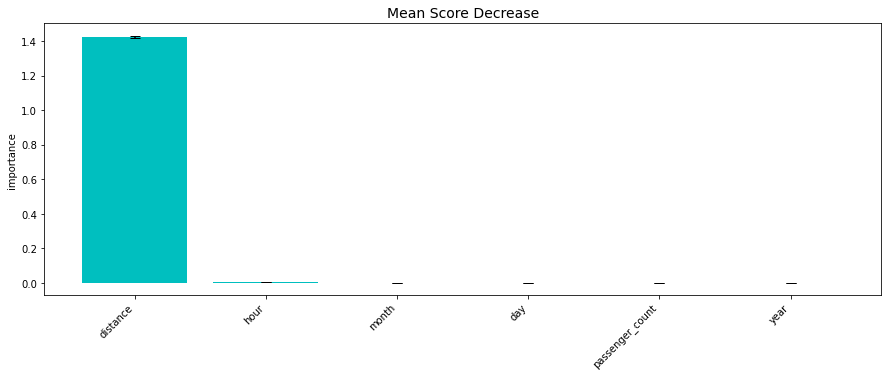

In [10]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True)

# Evaluate

In [11]:
from jcopml.plot import plot_residual

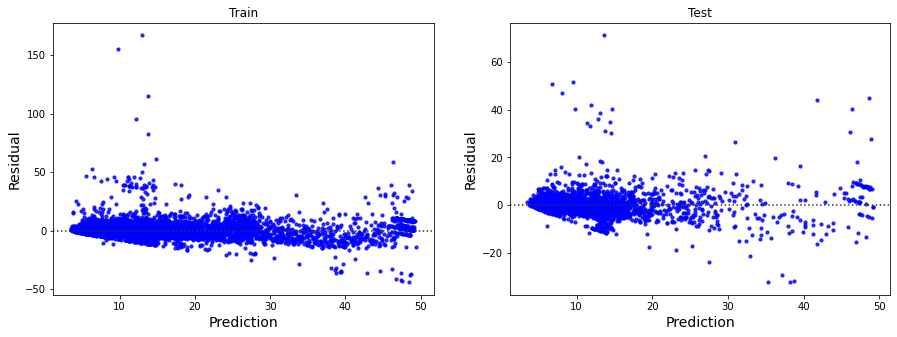

In [12]:
plot_residual(X_train, y_train, X_test, y_test, model)

### Masih saja ada unbalanced, mari kita cek datanya

In [13]:
df_analysis = X_train.copy()

pred = model.predict(X_train)
error = np.abs(pred - y_train)

df_analysis['fare'] = y_train.copy()
df_analysis['error'] = error
df_analysis.sort_values("error", ascending=False).head(10)

,passenger_count,year,month,day,hour,distance,fare,error
1335,1.0,2013,1,2,20,0.000000,180.00,166.982355
1483,1.0,2009,8,4,21,0.000416,165.00,155.268923
6630,1.0,2014,5,4,1,0.000000,128.83,115.046837
14142,1.0,2014,12,4,10,0.045860,108.00,95.862995
12915,1.0,2011,9,2,1,0.000000,96.00,82.187706
10524,1.0,2010,5,1,14,0.000000,75.80,60.963633
12349,1.0,2010,5,5,15,0.434492,104.67,58.396059
1494,1.0,2009,9,1,14,0.000031,70.00,56.731318
2432,1.0,2012,11,4,1,0.003817,58.60,52.301797
2346,1.0,2009,2,5,0,0.000000,63.00,50.088297


In [14]:
df[df.fare_amount < 0]

,fare_amount,passenger_count,year,month,day,hour,distance
2039,-2.9,1.0,2010,3,1,23,0.002331
2486,-2.5,1.0,2015,3,6,5,0.000313
13032,-3.0,4.0,2013,8,4,8,0.001425
